# Mechanistic modeling of VMHvl line attractor dynamics

By Charles Xu @ Caltech, 2024.

This notebook builds on the work by Isa in 2024 to further generalize on other plausible mechanisms of the implementation of the VMHvl line attractor.

## Environment

In [53]:
from netpyne import specs, sim, analysis
import numpy as np
import matplotlib.pyplot as plt
import random

In [54]:
## Create NetParams and SimConfig objects

# Model 1
netParams1 = specs.NetParams()
simConfig1 = specs.SimConfig()

# Model 2
netParams2 = specs.NetParams()
simConfig2 = specs.SimConfig()

## Neuron model

In [55]:
## Excitatory network

# Network parameters
N = 1000
x1_percentage = 0.1
x2_percentage = 0.1
taum = 20   # ms, membrane time constant

# Number of neurons in each population
num_x1 = int(round((N / 5) * x1_percentage))
num_x2 = int(round((N / 5) * x2_percentage))
num_other = N - num_x1 - num_x2

# Create populations
HH_params = {
    'secs': {
        'soma': {
            'geom': {},
            'mechs': {
                'hh': {'gnabar': 0.12, 'gkbar': 0.036, 'gl': 0.003, 'el': -54.3}
            }
        }
    }
}
netParams1.cellParams['hh'] = HH_params

In [56]:
# Add populations to netParams for model 1
netParams1.popParams['x1'] = {'cellType': 'hh', 'numCells': num_x1}
netParams1.popParams['x2'] = {'cellType': 'hh', 'numCells': num_x2}
netParams1.popParams['other'] = {'cellType': 'hh', 'numCells': num_other}

In [57]:
netParams1.popParams

{x1: {'cellType': 'hh', 'numCells': 20}, x2: {'cellType': 'hh', 'numCells': 20}, other: {'cellType': 'hh', 'numCells': 960}}

## Network topology

In this section, we will specify the network connectivity by defining `netParams.connParams` parameters.

In [58]:
## Define synaptic mechanism

taus = 30   # ms, synaptic time constant
netParams1.synMechParams['exc'] = {'mod': 'ExpSyn', 'tau': taus, 'e': 0}
# netParams.synMechParams['exc'] = {'mod': 'Exp2Syn', 'tau1': 0.1, 'tau2': 5.0, 'e': 0}

In [59]:
## Initialize random connectivity

# General connectivity parameters
prob_conn = 0.01  # Sparse connectivity
weight = 0.9
delay = 1.0

# Connect neurons randomly with specified probability
netParams1.connParams['randConnect'] = {
    'preConds': {'pop': ['x1', 'x2', 'other']},
    'postConds': {'pop': ['x1', 'x2', 'other']},
    'synMech': 'exc',
    'weight': weight,
    'delay': delay,
    'probability': prob_conn
}

In [60]:
## Subnetwork connectivity

# Subnetwork parameters
subnetwork_percentage = 0.2
N_sub = int(round(N * subnetwork_percentage)) # Subnetwork size
prob_subnet = 0.36  # Functional connectivity identified in Vinograd*, Nair*, et al. (2024)
                    # Note that this number indicates the functional connectivity among x1 neurons originally in the paper

# Generate explicit subnetwork connectivity
subnet_conn_mat = np.random.choice([0, 1], size=(N_sub, N_sub), p=[1 - prob_subnet, prob_subnet])
subnet_conn_list = list(zip(*tuple(i * 5 for i in np.nonzero(subnet_conn_mat))))

# Connect neurons within the subnetwork
netParams1.connParams['subnetConnect'] = {
    'preConds': {'pop': ['x1', 'x2', 'other']},    # 
    'postConds': {'pop': ['x1', 'x2', 'other']},   # Change to 'x1' assuming x1 neurons form the subnetwork
    'synMech': 'exc',
    'weight': weight,
    'delay': delay,
    'connList': subnet_conn_list
}

## Stimulation

In [61]:
# Input parameters
t_on = 2.5 * 1e3    # Convert to ms
t_dur = 2.0 * 1e3   # 2 s duration
t_interval = 20.0 * 1e3  # 20 s interval with 2 s pulse
n_pulses = 4

for i in range(n_pulses):
    t_start = t_on + i * (t_interval + t_dur)
    netParams1.stimSourceParams['pulse' + str(i)] = {
        'type': 'IClamp',
        'del': t_start,
        'dur': 2000,
        'amp': 10
    }

In [62]:
# Generate stimulation connections
stim_prob = 0.2 # Probability of stimulation connections
stim_conn_sample = random.sample(range(N), round(stim_prob * N))
stim_conn_sample.sort()

for i in range(n_pulses):
    netParams1.stimTargetParams['pulse' + str(i) + '->network'] = {
        'source': 'pulse' + str(i),
        'sec':'soma', 
        'loc': 0.5,
        'conds': {'pop': ['x1', 'x2', 'other'], 'cellList': stim_conn_sample}
    }

## Simulation

In [63]:
# Simulation parameters
simConfig1.duration = 200 * 1e3  # Simulation time in ms
simConfig1.dt = 0.001 * 1e3      # Timestep in ms

# Recording options
simConfig1.recordCells = ['all']
simConfig1.recordTraces = {
    'V_soma':{'sec':'soma','loc':0.5,'var':'v'}
    # 'spikes': {'conds': {'pop': ['x1', 'x2']}}
}
simConfig1.recordStep = 0.1  # Step size in ms

# Save options
simConfig1.filename = 'hypothalamic_sim'  # Set filename
simConfig1.saveJson = True  # Save to JSON for analysis

# Analysis and plotting
simConfig1.analysis['plotRaster'] = {'orderBy': 'pop', 'popRates': True}
simConfig1.analysis['plotTraces'] = {'include': [('x1', 0), ('x2', 0)]}
simConfig1.analysis['plotSpikeStats'] = {'stats': ['rate', 'isicv', 'sync']}

In [64]:
# Set a random seed for reproducibility if needed
simConfig1.hParams['randseed'] = 1

In [65]:
# Create network and run simulation
sim.createSimulateAnalyze(netParams=netParams1, simConfig=simConfig1)


Start time:  2024-09-24 16:21:27.570596

Creating network of 3 cell populations on 1 hosts...
  Number of cells on node 0: 1000 
  Done; cell creation time = 0.05 s.
Making connections...


## Analysis

Preparing spike data...
Plotting raster...


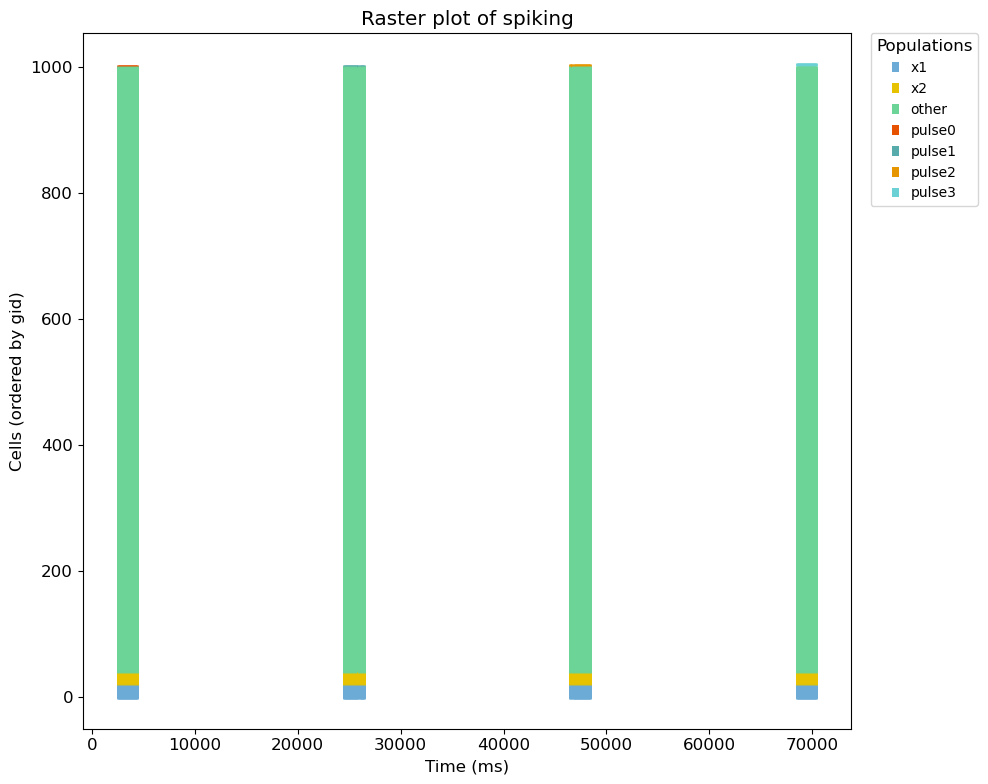

In [48]:
analysis.plotRaster()

Preparing spike data...
Plotting spike frequency...


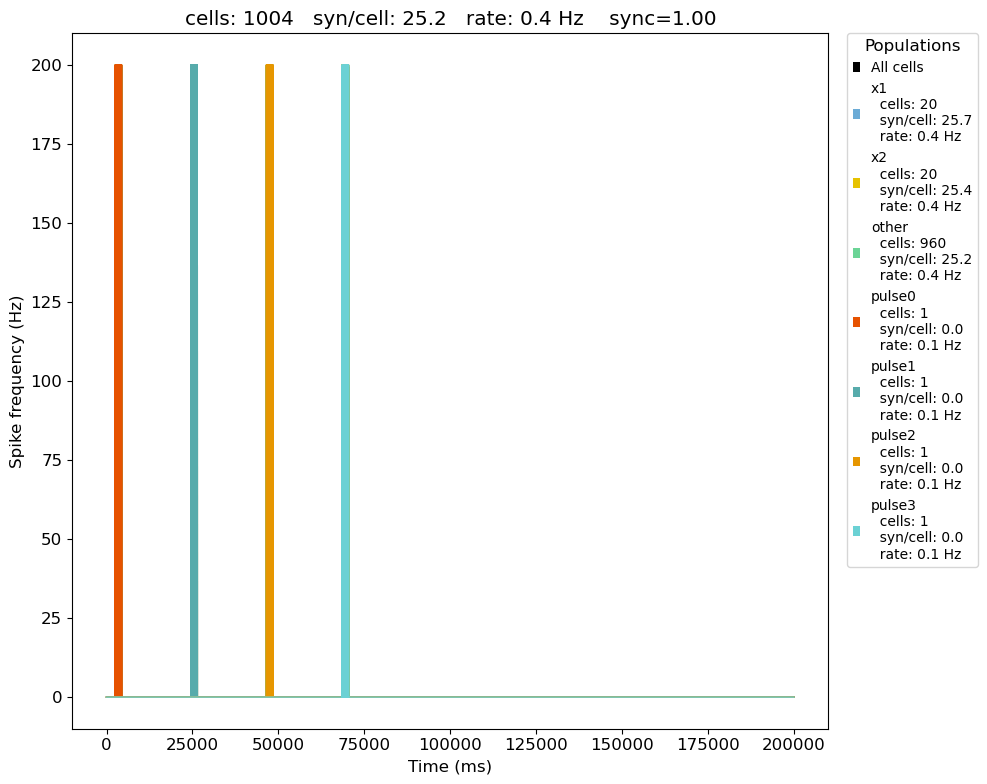

In [53]:
analysis.plotSpikeHist()

Plotting firing rate power spectral density (PSD) ...


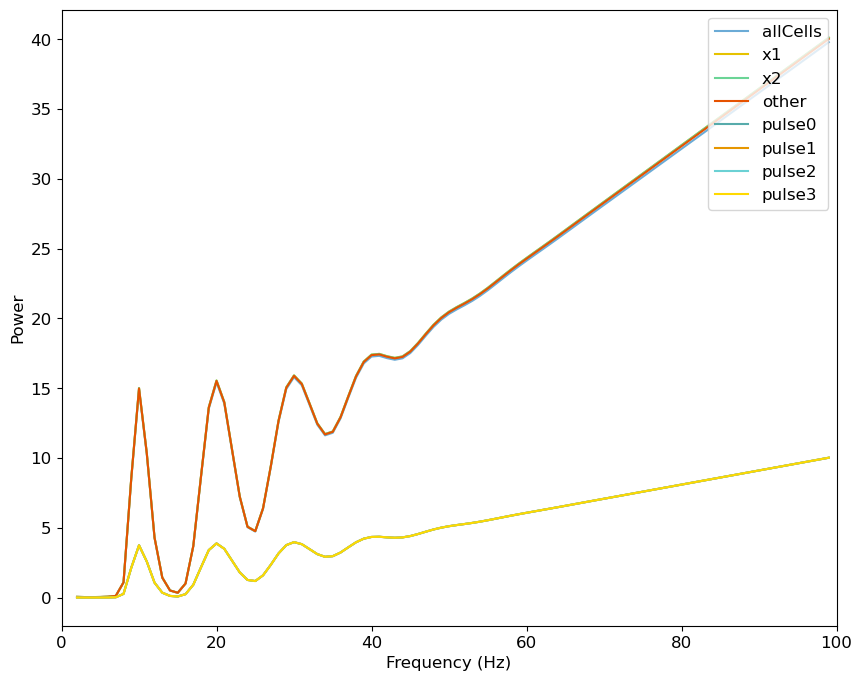

(<Figure size 1000x800 with 1 Axes>,
 {'allSignal': [array([ 0.06321238,  0.05791707,  0.04720882,  0.04544961,  0.05159429,
           0.07024533,  0.13003797,  1.09157911,  8.51005874, 14.89798263,
          10.29075808,  4.28352786,  1.43488966,  0.51533087,  0.3535071 ,
           1.01144339,  3.67255167,  8.65271777, 13.5334483 , 15.43505488,
          13.90687823, 10.54614932,  7.19344721,  5.05052943,  4.7396998 ,
           6.3604497 ,  9.34718023, 12.58902777, 14.94867479, 15.79898239,
          15.21965505, 13.81520305, 12.39595412, 11.62917275, 11.8135576 ,
          12.84427433, 14.32070032, 15.75833988, 16.78505786, 17.27396777,
          17.32481746, 17.15990995, 17.04263231, 17.14790264, 17.52351813,
          18.10465447, 18.76534371, 19.39631087, 19.91922068, 20.33042377,
          20.65257474, 20.94737408, 21.2621505 , 21.6216213 , 22.02167846,
          22.45490593, 22.89295607, 23.32385726, 23.73996433, 24.13930375,
          24.53295993, 24.92393219, 25.31757457, 2

In [49]:
analysis.plotRatePSD()

In [50]:
# Extract the data
spike_times = sim.allSimData['spkt']
spike_ids = sim.allSimData['spkid']

# Compute firing rates for x1 and x2 populations
from netpyne.analysis.spikes import calculateRates

rates = calculateRates(timeRange=[0, simConfig.duration])

# Extract and plot ramping activity
x1_cells = sim.net.allPops['x1']['cellGids']
x1_rates = [rates[gid] for gid in x1_cells]

plt.figure()
plt.plot(x1_rates)
plt.title('Ramping Activity of x1 Neurons')
plt.xlabel('Neuron Index')
plt.ylabel('Firing Rate (Hz)')
plt.show()

ImportError: cannot import name 'calculateRates' from 'netpyne.analysis.spikes' (/home/charlesxu/anaconda3/envs/neuraldynamics/lib/python3.9/site-packages/netpyne/analysis/spikes.py)